# Actual Implementation

In [1]:
import train as T

In [19]:
# Configuration
sims = ['TNG50', 'TNG100', 'Eagle100', 'Simba100']
config = {
    'obs': 'mags',
    'train_sim': sims[:2],
    'batch_size': 64,
    'num_epochs': 100,
    'lr': 0.001,
    'feature_layers': [128, 64, 32], 
    'label_layers': [32, 16, 8], 
    'domain_layers': [32, 16, 8], 
    'es_patience': 5,
    'es_min_delta': 0.005,
    'num_domains': len(sims)-1,
    'input_dim': 5,
    'alpha': 0.0
}

# hyper parameters - priors
# alpha - 0 to 1e3 (log scale)
# lr - 0.01 to 2e-5 (log scale)

In [20]:
# Train
T.train_dann(config, use_wandb=False, plots=True)

/opt/homebrew/Caskroom/miniforge/base/envs/haloflow/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1: 100%|██████████| 247/247 [00:00<00:00, 313.04it/s]


Loss task: 0.2232983112335205, Loss domain: 0.2457350194454193
Epoch 1/100
Train Loss: 1.3057, Test Loss: 0.6851, Domain Accuracy: 0.8780


Epoch 2: 100%|██████████| 247/247 [00:00<00:00, 283.48it/s]


Loss task: 0.9375877380371094, Loss domain: 0.5424455404281616
Epoch 2/100
Train Loss: 0.9393, Test Loss: 0.5683, Domain Accuracy: 0.8774


Epoch 3:   1%|          | 3/247 [00:00<00:01, 162.86it/s]


KeyboardInterrupt: 

In [21]:
import torch
from haloflow.dann.model import DANN, build_from_config
fp = '/Users/nikhilgaruda/Documents/Astronomy_Research/haloflow/data/hf2/dann/models/dann_model_TNG50_TNG100_to_Eagle100_mags_lr0.001_bs64_e22_2025-03-16.pt'

model = build_from_config(DANN, config)
model.load_state_dict(torch.load(fp, map_location=torch.device('cpu')))

<All keys matched successfully>

In [26]:
import haloflow.config as C
from haloflow.dann.data_loader import SimulationDataset

dataset = SimulationDataset(
    sims=sims, 
    obs=config['obs'],
    data_dir=C.get_dat_dir(),
)
train_loader, test_loader = dataset.get_train_test_loaders(
    train_sims=config['train_sim'],
    test_sim=sims[-1],
    batch_size=config['batch_size'],
)
scaler = dataset.scaler_Y

data = dataset.data
y_test = data['Eagle100']['Y_test']
x_test = data['Eagle100']['X_test']
x_test = torch.tensor(x_test, dtype=torch.float32)

In [27]:
min(y_test[:, 0]), max(y_test[:, 0]), min(y_test[:, 1]), max(y_test[:, 1])

(np.float64(10.0009),
 np.float64(12.1611),
 np.float64(11.5551),
 np.float64(14.4618))

In [28]:
# Get predictions
model.eval()
y_pred_scaled, _ = model(x_test)
# Inverse transform the predictions
y_pred = scaler.inverse_transform(y_pred_scaled.detach().numpy())

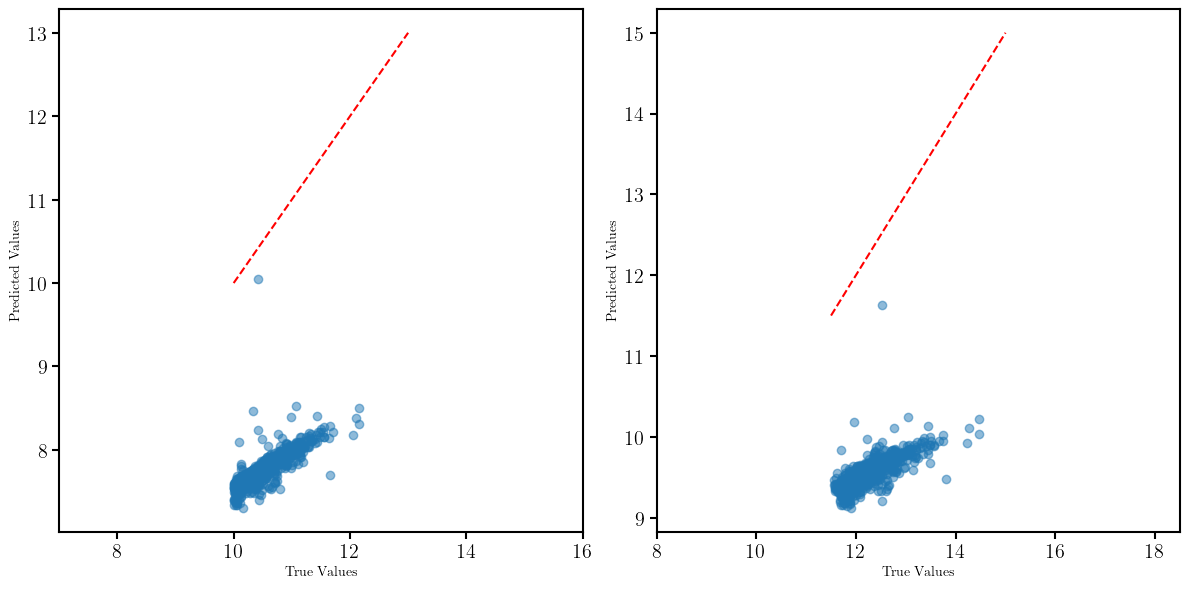

In [29]:
# Compare predictions with true values
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(y_test[:, 0], y_pred[:, 0], alpha=0.5)
ax[0].plot([10, 13], [10, 13], 'r--')
ax[0].set_xlabel('True Values')
ax[0].set_ylabel('Predicted Values')
# ax[0].set_xlim(10, 13)
# ax[0].set_ylim(10, 13)

ax[1].scatter(y_test[:, 1], y_pred[:, 1], alpha=0.5)
ax[1].plot([11.5, 15], [11.5, 15], 'r--')
ax[1].set_xlabel('True Values')
ax[1].set_ylabel('Predicted Values')
# ax[1].set_xlim(11.5, 15)
# ax[1].set_ylim(11.5, 15)

plt.tight_layout()

# Priors

In [5]:
dat = dataset.data['TNG50']['Y_train']

NameError: name 'dataset' is not defined

In [ ]:
sm = dat[:, 0]
hm = dat[:, 1]

(6717, 2)


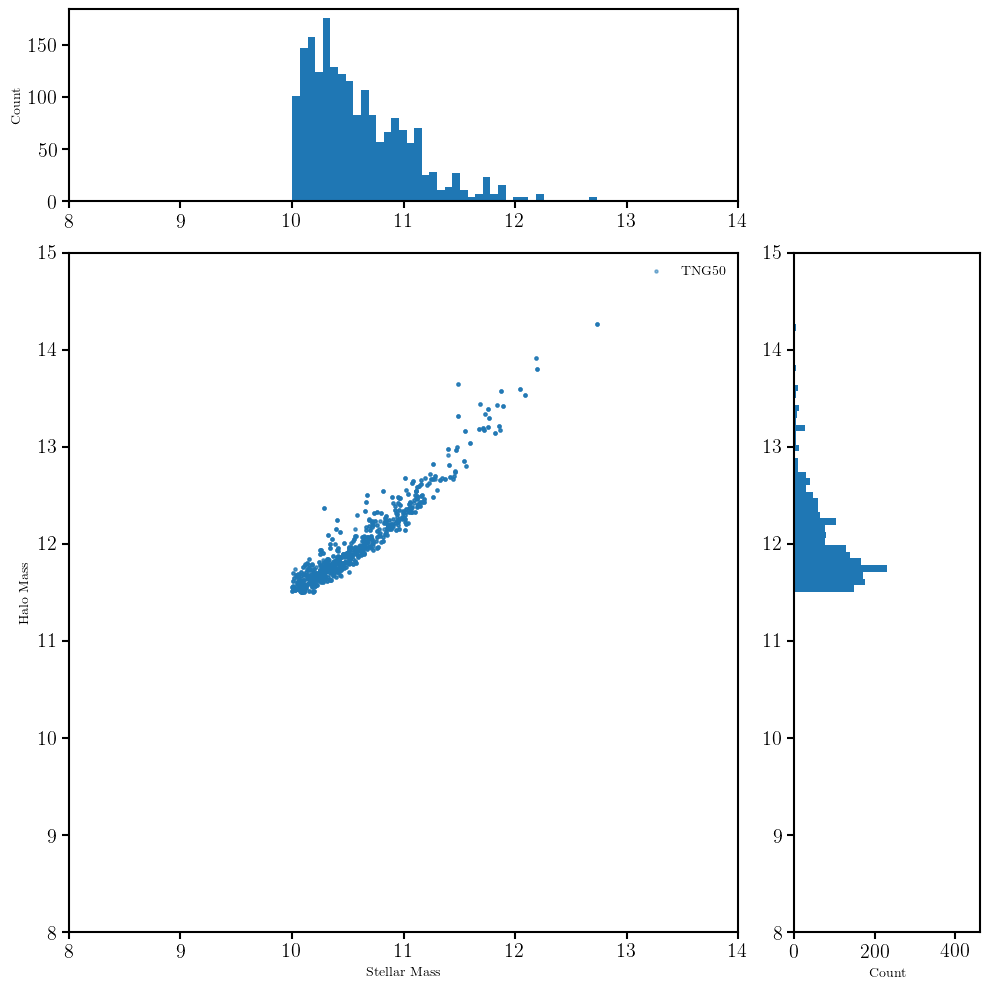

(13986, 2)


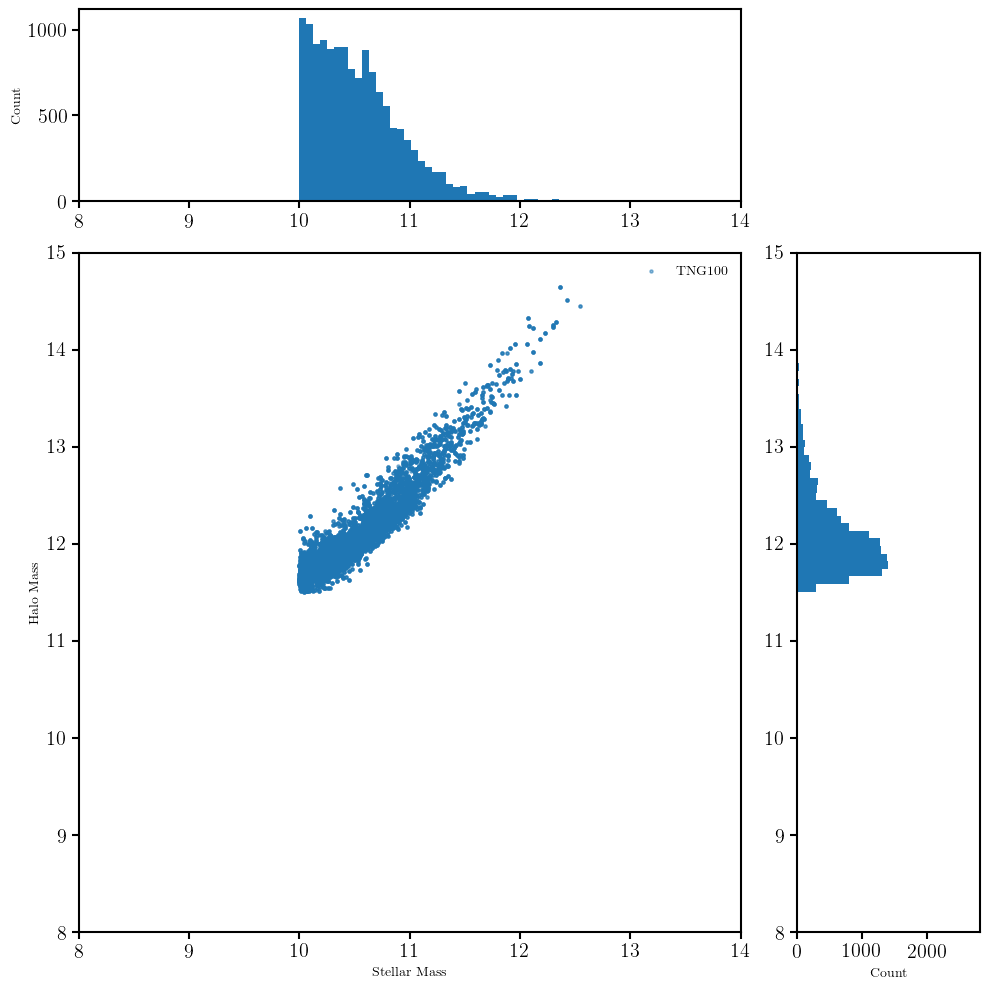

(8082, 2)


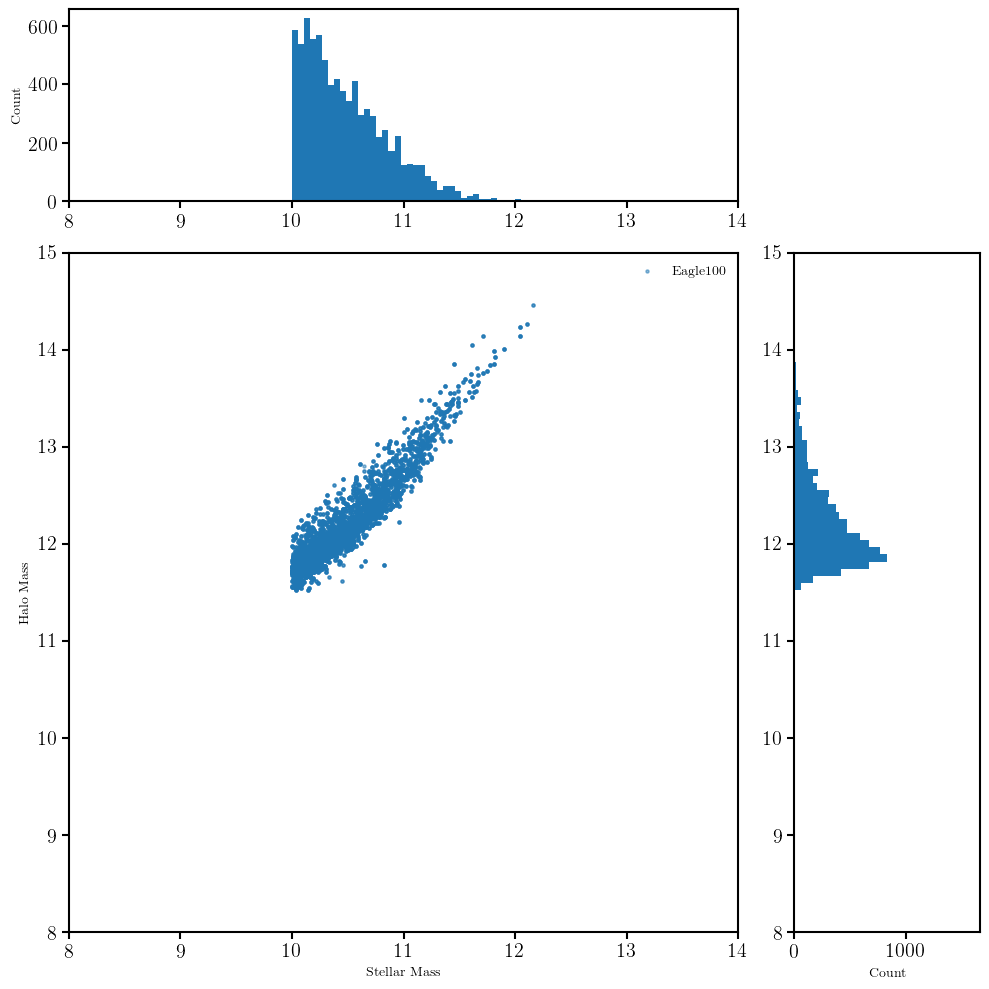

(8151, 2)


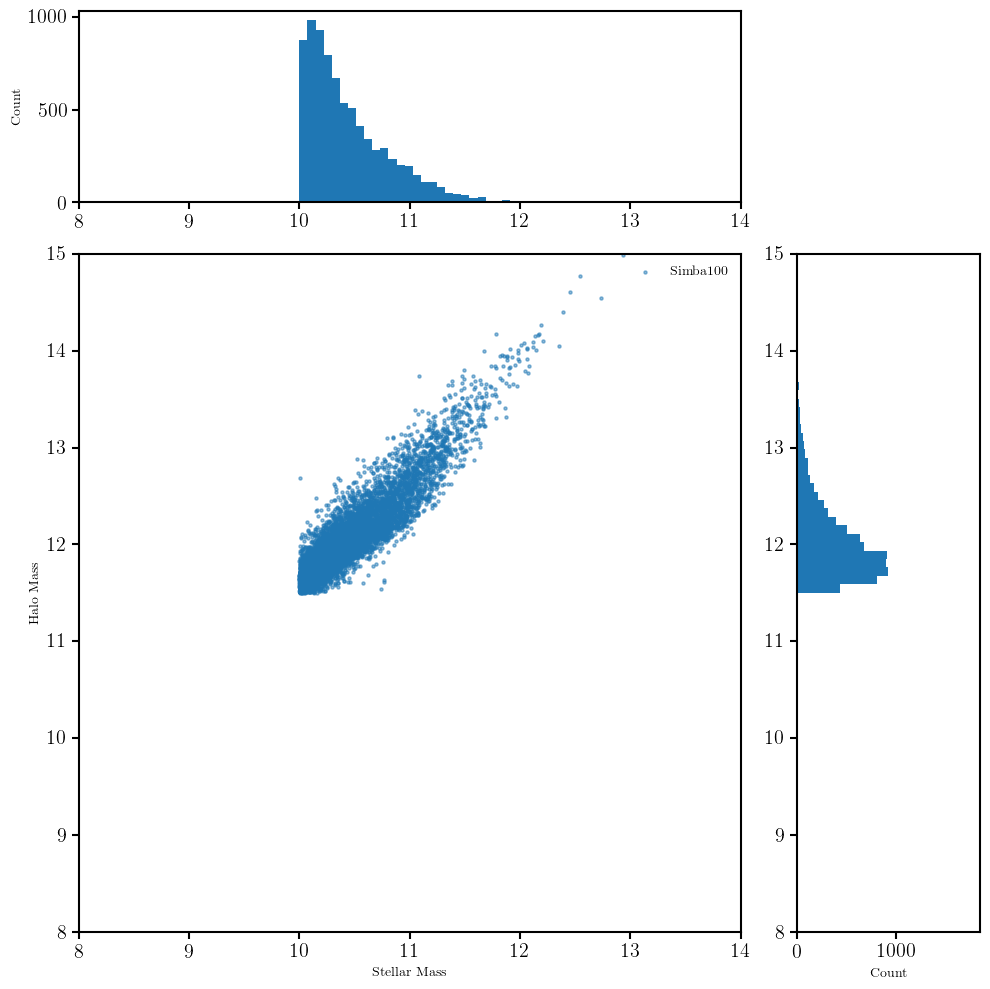

(20703, 2)


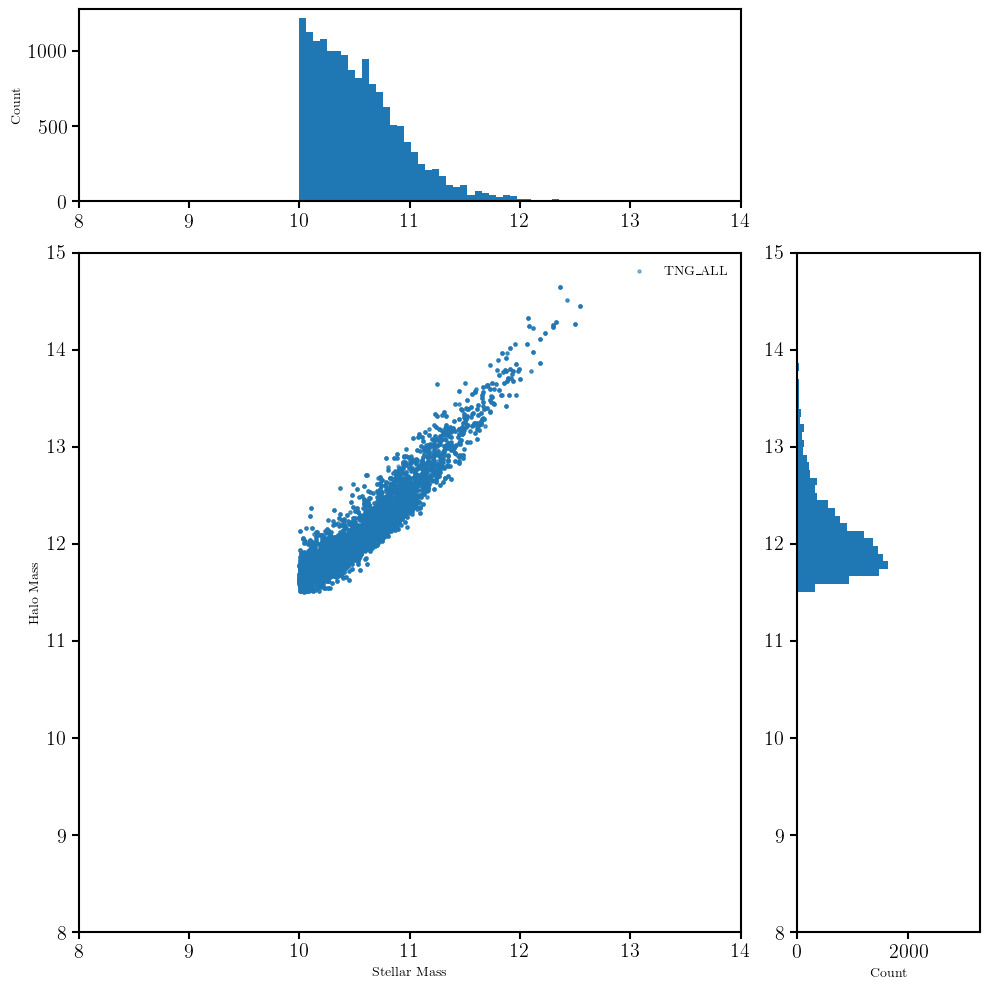

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

from haloflow.config import setup_plotting_config

setup_plotting_config()

for key in dataset.data.keys():
    # Example data
    dat = dataset.data[key]['Y_train']
    print(dat.shape)
    sm = dat[:, 0]
    hm = dat[:, 1]

#     mass_range_sm = [10.0, 13.]
#     mass_range_hm = [11.5, 15.]
#     mask_sm = (sm > mass_range_sm[0]) & (sm < mass_range_sm[1])
#     mask_hm = (hm > mass_range_hm[0]) & (hm < mass_range_hm[1])
#     sm = sm[mask_sm & mask_hm]
#     hm = hm[mask_sm & mask_hm]

    # Create the figure and grid layout
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(4, 4)

    # Main scatter plot
    ax_main = plt.subplot(gs[1:4, :3])

    ax_main.scatter(sm, hm, s=5, alpha=0.5, label=key)
    ax_main.set_xlabel('Stellar Mass')
    ax_main.set_ylabel('Halo Mass')
    ax_main.legend()

#     # Gray boxes outside the range
#     ax_main.axvspan(8, mass_range_sm[0], color='gray', alpha=0.5)
#     ax_main.axvspan(mass_range_sm[1], 15, color='gray', alpha=0.5)
#     ax_main.axhspan(9, mass_range_hm[0], color='gray', alpha=0.5)
#     ax_main.axhspan(mass_range_hm[1], 15, color='gray', alpha=0.5)

    # Set limits
    ax_main.set_xlim([8, 14])
    ax_main.set_ylim([8, 15])

    # Top histogram (stellar mass)
    ax_histx = plt.subplot(gs[0, :3], sharex=ax_main)
    ax_histx.hist(sm, bins=40, orientation='vertical')
    ax_histx.set_ylabel('Count')
    # ax_histx.set_xticks([])  # Remove x-ticks for the histogram

    # Right histogram (halo mass)
    ax_histy = plt.subplot(gs[1:4, 3], sharey=ax_main)
    ax_histy.hist(hm, bins=40, orientation='horizontal')
    ax_histy.set_xlabel('Count')
    # ax_histy.set_yticks([])  # Remove y-ticks for the histogram

    # Adjust layout
    plt.tight_layout()
    plt.show()

# test with the basic stuff

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

np.random.seed(23)

In [23]:
# random data (1, 2, 3, 4)
labels = [1, 2, 3, 4]

label_train = np.random.choice(labels, 100, replace=True) # truth
label_pred = np.random.choice(labels, 100, replace=True) # prediction

In [24]:
# make them tensors 
label_train = torch.tensor(label_train, dtype=torch.long)


In [25]:
(label_pred == label_train).sum().item() / len(label_train)

0.23

In [26]:
criterion_domain = nn.CrossEntropyLoss()

In [27]:
losses = []
for _ in range(100):
    label_pred = torch.tensor(label_pred, dtype=torch.long)
    # Convert label_pred to one-hot probabilities
    label_pred_one_hot = torch.zeros(len(label_pred), len(labels))
    label_pred_one_hot.scatter_(1, label_pred.unsqueeze(1) - 1, 1)  # subtract 1 since labels are 1-based
    loss = criterion_domain(label_pred_one_hot, label_train - 1)  # subtract 1 from target for 0-based indexing
    losses.append(loss.item())

/var/folders/1g/jdg8wj2j06g8cm00gnn6zvzc0000gn/T/ipykernel_16709/613041734.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_pred = torch.tensor(label_pred, dtype=torch.long)


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 100.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([1.01366818, 1.06366818, 1.11366818, 1.16366818, 1.21366818,
        1.26366818, 1.31366818, 1.36366818, 1.41366818, 1.46366818,
        1.51366818, 1.56366818, 1.61366818, 1.66366818, 1.71366818,
        1.76366818, 1.81366818, 1.86366818, 1.91366818, 1.96366818,
        2.01366818]),
 <BarContainer object of 20 artists>)

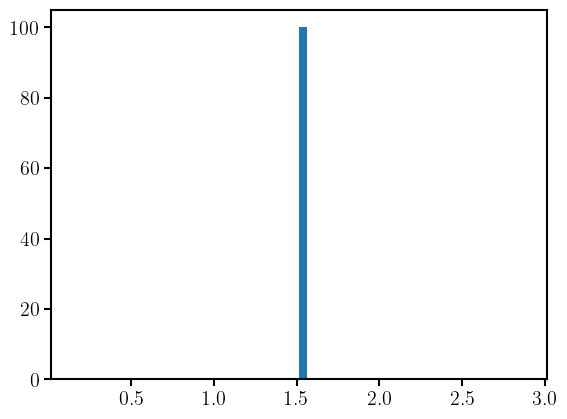

In [28]:
import matplotlib.pyplot as plt
plt.hist(losses, bins=20)